In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

In [2]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [3]:
# loading in the data
df = pd.read_csv('Police_Department_Incidents_-_Previous_Year__2016_.csv')

In [4]:
# checking to see whether the data was loaded correctly
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


In [5]:
# renaming the 2 columns so that it makes a little more sense.
col_rename = {'X': 'Lat', 'Y': 'Lon'}

df = df.rename(columns=col_rename)

In [6]:

# df = df.rename(columns=col_rename)

In [7]:
# dropping unnecessary columns
df = df.drop((['IncidntNum', 'Location', 'PdId', 'Descript']), axis = 1)

In [8]:
# sorting the dataframe by the date so that is starts on January 1, and ends on December 31.
df.sort_values(by=['Date', 'Category'], ascending=True, inplace=True)

In [9]:
df.head()

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Lat,Lon
108307,ARSON,Friday,01/01/2016 12:00:00 AM,16:56,SOUTHERN,"ARREST, BOOKED",MCCOPPIN ST / STEVENSON ST,-122.421749,37.771642
5,ASSAULT,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019
141,ASSAULT,Friday,01/01/2016 12:00:00 AM,02:04,TENDERLOIN,"ARREST, BOOKED",100 Block of TAYLOR ST,-122.410792,37.783695
142,ASSAULT,Friday,01/01/2016 12:00:00 AM,02:04,TENDERLOIN,"ARREST, BOOKED",100 Block of TAYLOR ST,-122.410792,37.783695
149,ASSAULT,Friday,01/01/2016 12:00:00 AM,02:15,TENDERLOIN,NONE,0 Block of 5THSTNORTH ST,-122.408649,37.784912


In [10]:
# making sure that the date is in the correct format
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
# setting the date to year/month/day
df['Date'] = df['Date'].dt.strftime('%Y/%m/%d')

In [12]:
# checking on the changes that I made to the dataframe
df.sample(5)

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Lat,Lon
51981,ROBBERY,Sunday,2016/06/26,15:30,RICHMOND,"ARREST, BOOKED",800 Block of LA PLAYA ST,-122.509895,37.772313
93552,OTHER OFFENSES,Wednesday,2016/09/14,15:30,SOUTHERN,NONE,0 Block of STEVENSON ST,-122.400032,37.789354
131260,LARCENY/THEFT,Sunday,2016/10/02,13:00,SOUTHERN,NONE,300 Block of BRYANT ST,-122.390947,37.785159
95939,SUSPICIOUS OCC,Friday,2016/11/11,06:40,RICHMOND,NONE,3000 Block of PACIFIC AV,-122.445504,37.792035
104753,ASSAULT,Saturday,2016/12/10,17:30,CENTRAL,"ARREST, BOOKED",700 Block of VALLEJO ST,-122.409213,37.798467


In [13]:
# checking to see if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150500 entries, 108307 to 111731
Data columns (total 9 columns):
Category      150500 non-null object
DayOfWeek     150500 non-null object
Date          150500 non-null object
Time          150500 non-null object
PdDistrict    150499 non-null object
Resolution    150500 non-null object
Address       150500 non-null object
Lat           150500 non-null float64
Lon           150500 non-null float64
dtypes: float64(2), object(7)
memory usage: 11.5+ MB


In [14]:
# there is only one missing value for the entire dataframe under the PdDistrict column. we will use a ffill.
df['PdDistrict'] = df['PdDistrict'].ffill()

In [15]:
# checking to see whether the missing value was filled or not. It was.
df['PdDistrict'].isnull().sum()

0

# Category

In [16]:
# counting the different categories withing the crime category column
catcount = pd.crosstab(index=df['Category'], columns='count')

In [17]:
catcount['count'].sort_values(ascending = False)

Category
LARCENY/THEFT                  40409
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                 

In [18]:
# there are a lot of crimes for the year 2016 that happened less than 1000 times. to make things easier on ourselves 
# we will look at only the crimes that have occurred more than 1000 times over the course of the year.
# LARCENY/THEFT                  40409
# OTHER OFFENSES                 19599
# NON-CRIMINAL                   17866
# ASSAULT                        13577
# VANDALISM                       8589
# VEHICLE THEFT                   6419
# WARRANTS                        5914
# BURGLARY                        5802
# SUSPICIOUS OCC                  5782
# MISSING PERSON                  4338
# DRUG/NARCOTIC                   4243
# ROBBERY                         3299
# FRAUD                           2635
# SECONDARY CODES                 1841
# TRESPASS                        1812
# WEAPON LAWS                     1658

In [19]:
cat = catcount.drop(['TREA', 'PORNOGRAPHY/OBSCENE MAT', 'GAMBLING', 'BAD CHECKS', 'SEX OFFENSES, NON FORCIBLE', 'LOITERING',
              'FAMILY OFFENSES', 'EXTORTION', 'SUICIDE', 'BRIBERY', 'RUNAWAY', 'EMBEZZLEMENT', 'LIQUOR LAWS',
              'SEX OFFENSES, FORCIBLE', 'STOLEN PROPERTY', 'RECOVERED VEHICLE', 'DISORDERLY CONDUCT', 'PROSTITUTION',
               'FORGERY/COUNTERFEITING', 'DRUNKENNESS', 'DRIVING UNDER THE INFLUENCE', 'ARSON', 'KIDNAPPING'],
                axis = 0)

In [20]:
cat.head(16)

col_0,count
Category,
ASSAULT,13577
BURGLARY,5802
DRUG/NARCOTIC,4243
FRAUD,2635
LARCENY/THEFT,40409
MISSING PERSON,4338
NON-CRIMINAL,17866
OTHER OFFENSES,19599
ROBBERY,3299


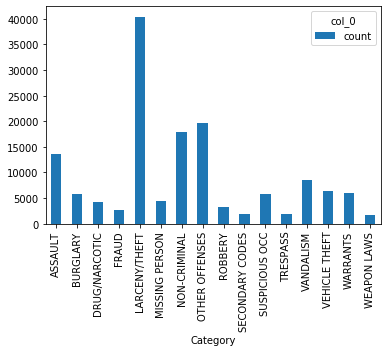

In [21]:
# after dropping everything that occured less than 1000 times over the course of the year, 
# we are left with 16 categories of crimes. Larceny/theft are the highest occuring crimes in SF for 2016.
cat.plot(kind='bar');

# DayOfWeek

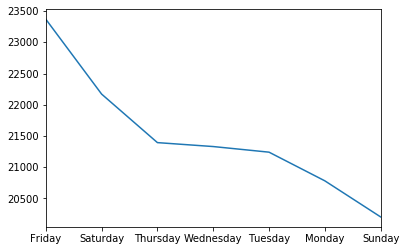

In [22]:
# I want to check to see what day of the week crimes are most likely to occur. 
df['DayOfWeek'].value_counts().plot();

In [23]:
# Not surprisingly, Friday, Saturday, and Thursday are the days with the most crimes commited but it is fairly even 
# accross the seven days of the week.
day = pd.crosstab(index=df['DayOfWeek'], columns='count')

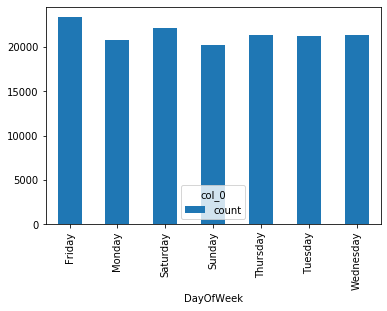

In [24]:
day.plot(kind = 'bar');

# Date

In [25]:
# knowing the dates that crimes occur the most will allow the police department to know when to staff appropriately 
date = df['Date'].value_counts()
date.head()

2016/01/01    558
2016/10/08    532
2016/04/01    525
2016/01/29    514
2016/12/14    507
Name: Date, dtype: int64

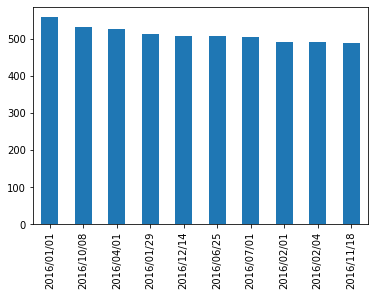

In [26]:
# here we can see the 10 "biggest" days for crime in SF. 
# I do not think it is a surprise that New Years is the day with the highest amount of crime
date.head(10).plot(kind = 'bar');

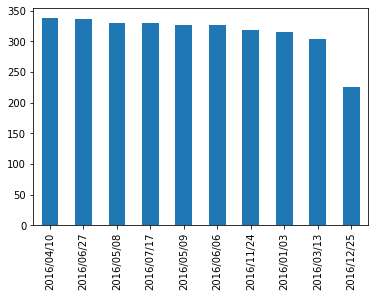

In [27]:
# here are the 10 days with the lowest amount of crime. Again, I do not think it is a surprise that christmas is the
# day with the least amount of crime.
date.tail(10).plot(kind = 'bar');

# Time

In [28]:
# The time that a crime occurs is important to know for law enforcement officials so that they can know where to best 
# allocate their resources
time = df['Time'].value_counts()

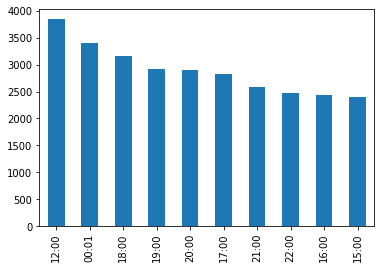

In [29]:
# looking at the graph of the 10 times that crimes occur the most.
# crimes occur most often in the late afternoon to early night time. 

# military time
time.head(10).plot(kind = 'bar');

# PdDistrict

In [30]:
# now lets take a look at which police department is called upon the most.
dist = df['PdDistrict'].value_counts()

In [31]:
# as we can clearly see from the numbers and graph below, the southern district is the most crime ridden.
dist.head()

SOUTHERN    28446
NORTHERN    20100
MISSION     19503
CENTRAL     17666
BAYVIEW     14303
Name: PdDistrict, dtype: int64

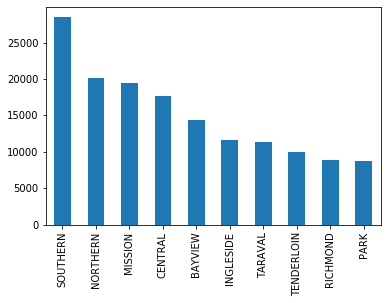

In [32]:
dist.plot(kind = 'bar');

# Resolution

In [33]:
# the resolution is what happens when the complaintant is contacted by the police. 
# there are two main data points in this dataset, with the others making up a very little percentage. 

In [34]:
res = df['Resolution']

In [35]:
res.value_counts()

NONE                                      107780
ARREST, BOOKED                             39416
UNFOUNDED                                   1608
JUVENILE BOOKED                             1056
EXCEPTIONAL CLEARANCE                        371
ARREST, CITED                                144
CLEARED-CONTACT JUVENILE FOR MORE INFO        58
NOT PROSECUTED                                22
LOCATED                                       20
PSYCHOPATHIC CASE                             17
JUVENILE CITED                                 3
COMPLAINANT REFUSES TO PROSECUTE               2
JUVENILE DIVERTED                              2
PROSECUTED BY OUTSIDE AGENCY                   1
Name: Resolution, dtype: int64

In [36]:
reso = res.value_counts().head(2)

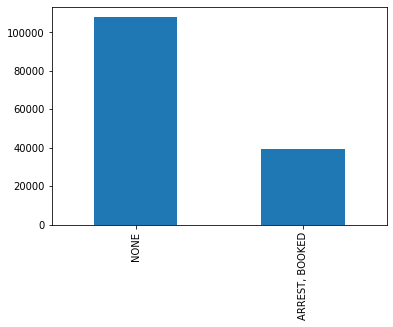

In [37]:
reso.plot(kind = 'bar');

# the vast majority of complaints end up in the "none" column. This means there is a lot of wasted time and effort
# on the police departments part. Around 70% of the time that police were called in 2016, the police left without 
# doing anything. 

# Amount of Crimes Per Month

Total amount of crimes in January: 12946


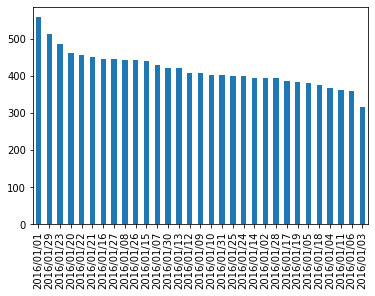

In [38]:
filtdf1 = df[(df['Date'] >= '2016/01/01') & (df['Date'] <='2016/01/31')]
filtdf1['Date'].value_counts().plot(kind = 'bar');
print("Total amount of crimes in January:", filtdf1['Date'].value_counts().sum())

# January
# Top 3 days for crime:
# Jan 1, 29, 23
# Lowest 3 days for crime:
# Jan 11, 6, 3

Total amount of crimes in February: 12092


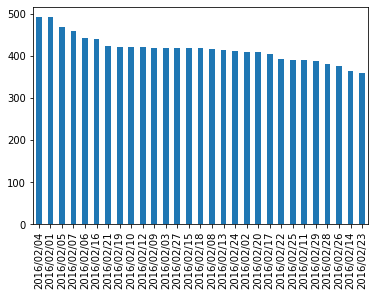

In [39]:
filtdf2 = df[(df['Date'] >= '2016/02/01') & (df['Date'] <='2016/02/31')]
filtdf2['Date'].value_counts().plot(kind = 'bar');
print("Total amount of crimes in February:", filtdf2['Date'].value_counts().sum())

# February
# Top 3 days for crime:
# Feb 1, 4, 7
# Lowest 3 days for crime:
# Feb 26, 14, 23

Total amount of crimes in March: 12362


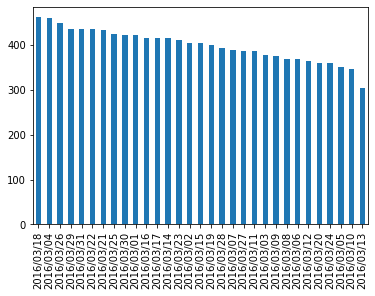

In [40]:
filtdf3 = df[(df['Date'] >= '2016/03/01') & (df['Date'] <='2016/03/31')]
filtdf3['Date'].value_counts().plot(kind = 'bar');
print("Total amount of crimes in March:", filtdf3['Date'].value_counts().sum())


# March
# Top 3 days for crime:
# Mar 18, 4, 26
# Lowest 3 days for crime:
# Mar 5, 10, 13

Total amount of crimes in April: 12317


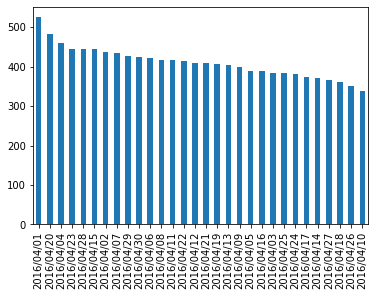

In [41]:
filtdf4 = df[(df['Date'] >= '2016/04/01') & (df['Date'] <='2016/04/31')]
filtdf4['Date'].value_counts().plot(kind = 'bar');
print("Total amount of crimes in April:", filtdf4['Date'].value_counts().sum())

# April
# Top 3 days for crime:
# Apr 1, 20, 4
# Lowest 3 days for crime:
# Apr 18, 26, 10

In [42]:
# # to save space I have written the code but I have not entered it
# # May
# filtdf5 = df[(df['Date'] >= '2016/05/01') & (df['Date'] <='2016/05/31')]
# filtdf5['Date'].value_counts().plot(kind = 'bar');
# # June
# filtdf6 = df[(df['Date'] >= '2016/06/01') & (df['Date'] <='2016/06/31')]
# filtdf6['Date'].value_counts().plot(kind = 'bar');
# # July
# filtdf7 = df[(df['Date'] >= '2016/07/01') & (df['Date'] <='2016/07/31')]
# filtdf7['Date'].value_counts().plot(kind = 'bar');
# # August
# filtdf8 = df[(df['Date'] >= '2016/08/01') & (df['Date'] <='2016/08/31')]
# filtdf8['Date'].value_counts().plot(kind = 'bar');
# # September
# filtdf9 = df[(df['Date'] >= '2016/09/01') & (df['Date'] <='2016/09/31')]
# filtdf9['Date'].value_counts().plot(kind = 'bar');
# # October
# filtdf10 = df[(df['Date'] >= '2016/10/01') & (df['Date'] <='2016/10/31')]
# filtdf10['Date'].value_counts().plot(kind = 'bar');
# # November
# filtdf11 = df[(df['Date'] >= '2016/11/01') & (df['Date'] <='2016/11/31')]
# filtdf11['Date'].value_counts().plot(kind = 'bar');
# # December
# filtdf12 = df[(df['Date'] >= '2016/12/01') & (df['Date'] <='2016/12/31')]
# filtdf12['Date'].value_counts().plot(kind = 'bar');

# Time Series Analysis

In [43]:
# in order to fully understand crime within san francisco, i will perform a time series analysis. 
# importing necessary packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error 

In [44]:
# setting the algorithms to usable names
le = LabelEncoder()
lr = LinearRegression()

In [45]:
# dropping unnecessary columns
ts1 = df.drop(['Address', 'Lat', 'Lon'], axis = 1)

In [46]:
# getting the time in a usable format
ts1['Date'] = pd.to_datetime(df['Date'])

In [47]:
ts1['Date'] = ts1['Date'].dt.strftime('%Y/%m/%d')

In [48]:
# in order to graph our time series we will need to turn the categorical data into numbers
labelcat = le.fit_transform(ts1['Category'])

# this is the code for the other categorical data that the user can use to make different time series with
# labelday = le.fit_transform(ts['DayOfWeek'])
# labelpd = le.fit_transform(ts['PdDistrict'])
# labelres = le.fit_transform(ts['Resolution'])

In [49]:
# making sure that the label encoding worked
labelcat

array([ 0,  1,  1, ..., 38, 38, 38])

In [50]:
# the classes within the label endoded column
le.classes_

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES, FORCIBLE',
       'SEX OFFENSES, NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

In [51]:
# resetting the data frame so that our category column is label encoded
ts1['Category'] = labelcat
# ts['DayOfWeek'] = labelday
# ts['PdDistrict'] = labelpd
# ts['Resolution'] = labelres

In [52]:
# making sure that it worked
ts1.head(2)

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution
108307,0,Friday,2016/01/01,16:56,SOUTHERN,"ARREST, BOOKED"
5,1,Friday,2016/01/01,21:35,NORTHERN,NONE


In [53]:
# checking out the data types and missing values
ts1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150500 entries, 108307 to 111731
Data columns (total 6 columns):
Category      150500 non-null int64
DayOfWeek     150500 non-null object
Date          150500 non-null object
Time          150500 non-null object
PdDistrict    150500 non-null object
Resolution    150500 non-null object
dtypes: int64(1), object(5)
memory usage: 8.0+ MB


            Crime Per Day
Date                     
2016/01/01            558
2016/01/02            395
2016/01/03            316
2016/01/04            366
2016/01/05            382


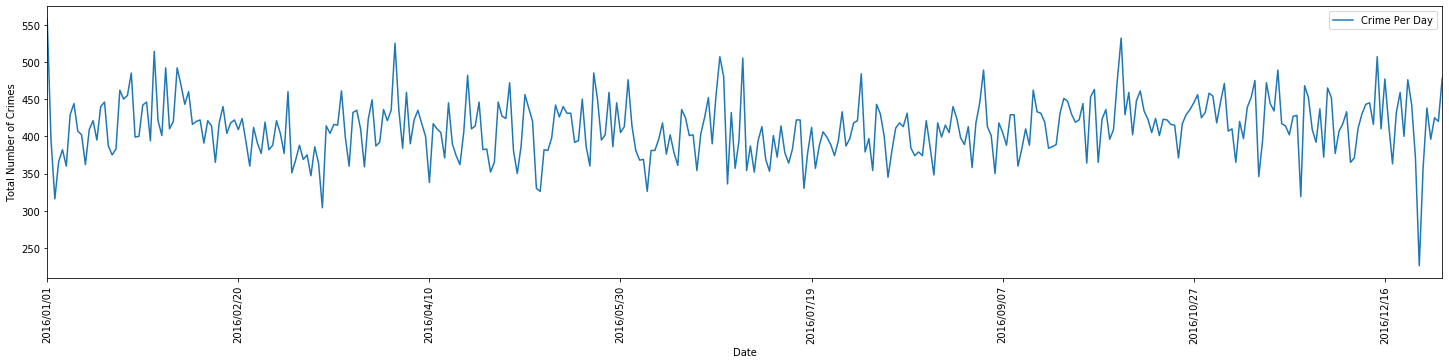

In [54]:
# this is a graph of the amount of crimes happening per day over the course of a year. 
grouped_single = ts1.groupby('Date').agg({'Category': ['count']})

# rename columns
grouped_single.columns = ['Crime Per Day']

print(grouped_single.head())
grouped_single.plot(figsize = (25,5));
plt.xticks(rotation = 90);
plt.ylabel('Total Number of Crimes');

In [55]:
# again, this is the code for any other time series that might want to be looked at
# grouped_single1 = ts1.groupby('Date').agg({'DayOfWeek': ['count']})
# grouped_single2 = ts1.groupby('Date').agg({'PdDistrict': ['count']})
# grouped_single3 = ts1.groupby('Date').agg({'Resolution': ['count']})

# grouped_single1.plot();
# grouped_single2.plot();
# grouped_single3.plot();


In [56]:
# reset index to get grouped columns back
grouped_single = grouped_single.reset_index('Date')
grouped_single.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
Date             366 non-null object
Crime Per Day    366 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


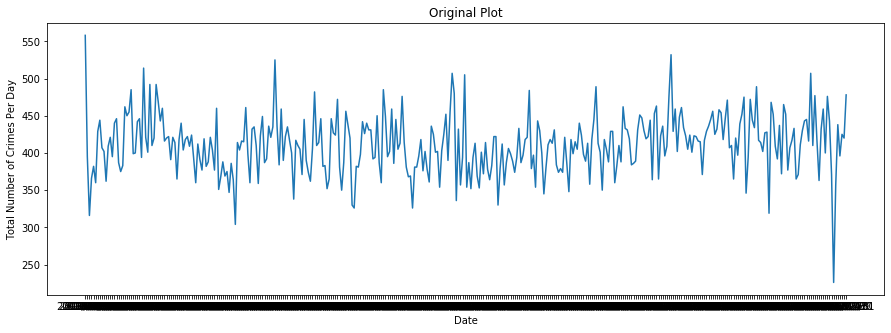

In [57]:
# there is so much data that the labels are cluttered. 
# The dates range from 1/1/2016-12/1/2016.
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Number of Crimes Per Day')
ax1.set_title('Original Plot')
ax1.plot('Date', 'Crime Per Day', data = grouped_single);

In [58]:
# there is a lot of data to go over in this data set. I wanted to see what it would look like with only 50% of the data
one_half = grouped_single.sample(frac = .25, random_state = np.random.randint(100))

In [59]:
# checking to see if it worked
one_half.head()

,Date,Crime Per Day
231,2016/08/19,386
46,2016/02/16,440
1,2016/01/02,395
110,2016/04/20,482
325,2016/11/21,402


In [60]:
# here we can see there is far less data than before
one_half.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 231 to 11
Data columns (total 2 columns):
Date             92 non-null object
Crime Per Day    92 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [61]:
one_half.index.name = None
one_half = one_half.sort_values(by = ['Date'], ascending = True)
one_half.head()

,Date,Crime Per Day
0,2016/01/01,558
1,2016/01/02,395
2,2016/01/03,316
3,2016/01/04,366
4,2016/01/05,382


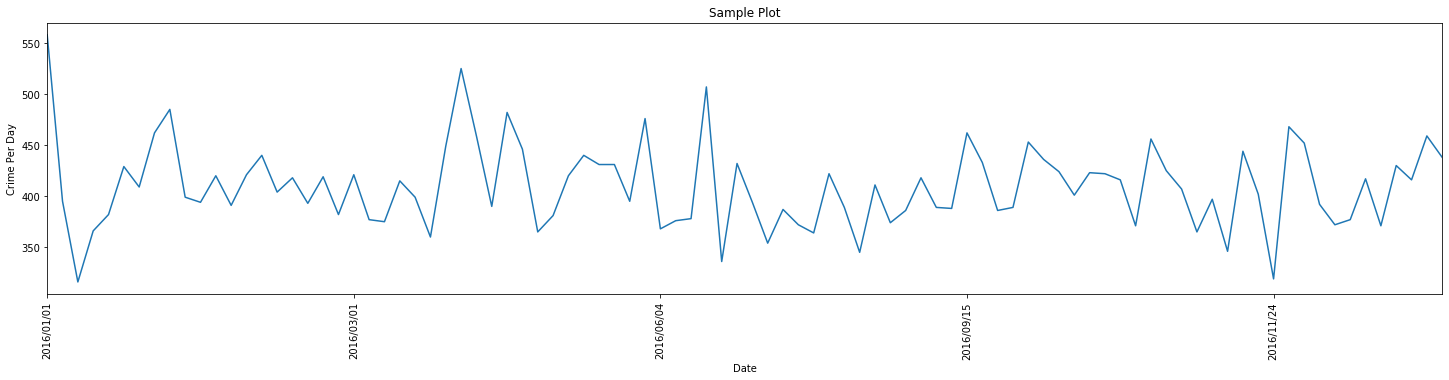

In [62]:
axes = one_half.plot('Date', 'Crime Per Day', legend = False, title = 'Sample Plot', figsize = (25,5));
axes.legend = None
axes.set_ylabel('Crime Per Day')
plt.xticks(rotation = 90);


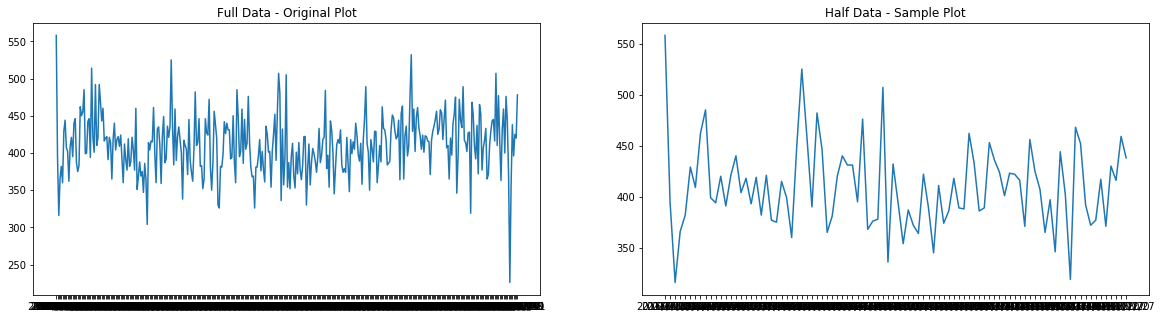

In [63]:
# plotting the two graphs side by side
# there is 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5));
axes[0].plot('Date', 'Crime Per Day', data = grouped_single);
axes[0].set_title('Full Data - Original Plot');
axes[1].plot('Date', 'Crime Per Day', data = one_half);
axes[1].set_title('Half Data - Sample Plot');

In [64]:
# grouped_single = grouped_single.reset_index()
# grouped_single.head()

In [65]:
grouped_single['Rolling Mean'] = grouped_single['Crime Per Day'].rolling(window = 30).mean()
grouped_single.head(10)

,Date,Crime Per Day,Rolling Mean
0,2016/01/01,558,NaN
1,2016/01/02,395,NaN
2,2016/01/03,316,NaN
3,2016/01/04,366,NaN
4,2016/01/05,382,NaN
5,2016/01/06,360,NaN
6,2016/01/07,429,NaN
7,2016/01/08,444,NaN
8,2016/01/09,407,NaN
9,2016/01/10,402,NaN


In [66]:
grouped_single.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
Date             366 non-null object
Crime Per Day    366 non-null int64
Rolling Mean     337 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [67]:
grouped_single.dropna(inplace = True)
# grouped_single.dropna()

In [68]:
grouped_single.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337 entries, 29 to 365
Data columns (total 3 columns):
Date             337 non-null object
Crime Per Day    337 non-null int64
Rolling Mean     337 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.5+ KB


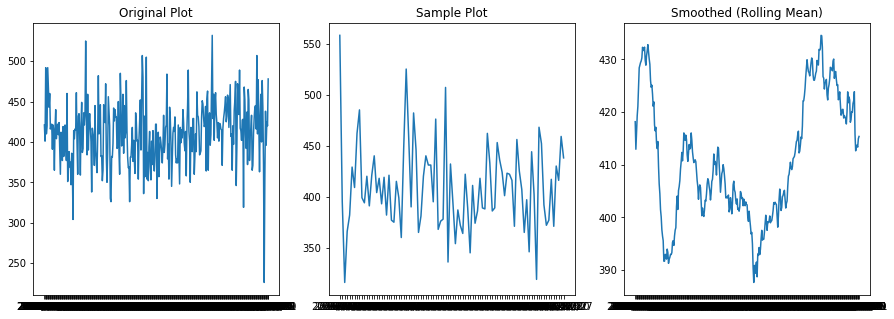

In [69]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5));
axes[0].plot('Date', 'Crime Per Day', data = grouped_single);
axes[0].set_title('Original Plot');
axes[1].plot('Date', 'Crime Per Day', data = one_half);
axes[1].set_title('Sample Plot');
axes[2].plot('Date', 'Rolling Mean', data = grouped_single);
axes[2].set_title('Smoothed (Rolling Mean)');

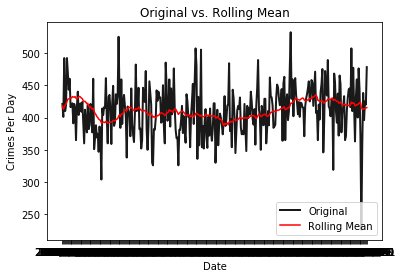

In [70]:
# this graph is to show the relationship between the original data set and the rolling mean 
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(grouped_single['Date'], grouped_single['Crime Per Day'], color = (0, 0, 0), linewidth = 2, alpha = .9, label = 'Original');
ax.plot(grouped_single['Date'], grouped_single['Rolling Mean'], color = (1, 0, 0), label = 'Rolling Mean');
ax.set_title('Smoothed (Rolling Mean)');
ax.set_title('Original vs. Rolling Mean');
ax.set_xlabel('Date');
ax.set_ylabel('Crimes Per Day');
ax.legend(loc = 'lower right');

In [71]:
grouped_single['Date'] = pd.to_datetime(grouped_single['Date'])
one_half['Date'] = pd.to_datetime(one_half['Date'])

In [72]:
grouped_single.head()

,Date,Crime Per Day,Rolling Mean
29,2016-01-30,421,418.166667
30,2016-01-31,401,412.933333
31,2016-02-01,492,416.166667
32,2016-02-02,410,419.300000
33,2016-02-03,420,421.100000


In [73]:
one_half.head()

,Date,Crime Per Day
0,2016-01-01,558
1,2016-01-02,395
2,2016-01-03,316
3,2016-01-04,366
4,2016-01-05,382


In [74]:
decomp = grouped_single.drop(columns = 'Rolling Mean')

In [75]:
decomp = decomp.set_index('Date')
decomp.head()

,Crime Per Day
Date,
2016-01-30,421
2016-01-31,401
2016-02-01,492
2016-02-02,410
2016-02-03,420


In [76]:
#Additive is used when seasonality variation is constant over time
df_decomp = sm.tsa.seasonal_decompose(decomp, model='additive')

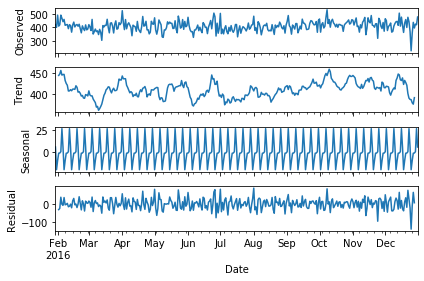

In [77]:
df_decomp.plot();

In [78]:
variables = pd.read_csv('Police_Department_Incidents_-_Previous_Year__2016_.csv')
variables = variables.drop((['IncidntNum', 'Location', 'PdId', 'Descript']), axis = 1)
variables['Date'] = pd.to_datetime(variables['Date'])
variables['Date'] = variables['Date'].dt.strftime('%Y/%m/%d')
variables['PdDistrict'] = variables['PdDistrict'].ffill()
labelcat1 = le.fit_transform(variables['Category'])
variables.sort_values(by=['Date', 'Category'], ascending=True, inplace=True)

# variables.sort_values(by=['Date', 'Category'], ascending=True, inplace=True)
# labelcat1 = le.fit_transform(variables['Category'])
grouped_cat1 = variables.groupby('Date').agg({'Category': ['count']})
grouped_cat1.columns = ['Crime Per Day']


v = grouped_cat1
price = v['Crime Per Day']
v.head()

,Crime Per Day
Date,
2016/01/01,558
2016/01/02,395
2016/01/03,316
2016/01/04,366
2016/01/05,382


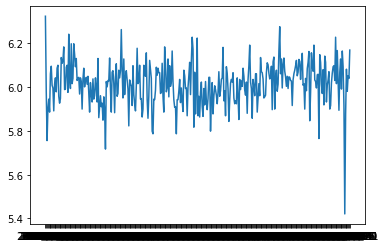

In [79]:
lnprice = np.log(price)
lnprice
plt.plot(lnprice);

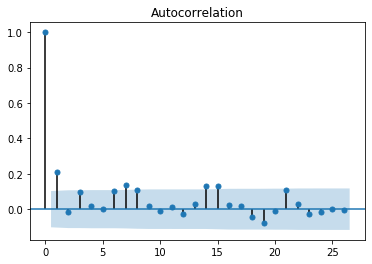

In [80]:
# acf1 = acf(lnprice)
# test_df = pd.DataFrame([acf1]).T
# test_df.columns = ['Autocorrelation']
# test_df.index += 1
# test_df.plot(kind = 'bar');


from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(lnprice)
pyplot.show()

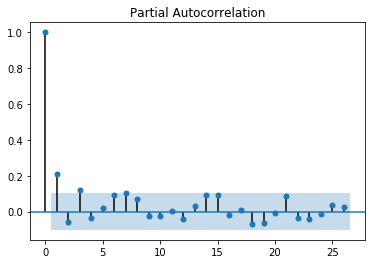

In [81]:
# pacf1 = pacf(lnprice)
# test_df = pd.DataFrame([pacf1]).T
# test_df.columns = ['Partial Autocorrelation']
# test_df.index += 1
# test_df.plot(kind = 'bar');

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(lnprice)
pyplot.show()

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


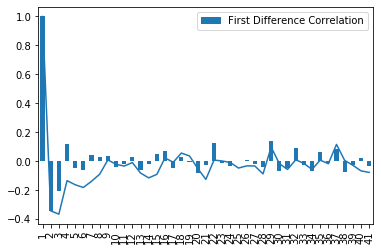

In [82]:
result = ts.adfuller(lnprice, 1)
result
lnprice_diff = lnprice - lnprice.shift()
diff = lnprice_diff.dropna()
acf_1_diff = acf(diff)
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First Difference Correlation']
test_df.index += 1
test_df.plot(kind = 'bar')
pacf_1_diff = pacf(diff)
plt.plot(pacf_1_diff)
plt.show()

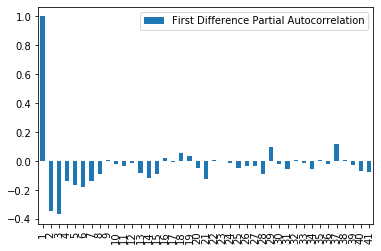

In [83]:
test_df = pd.DataFrame([pacf_1_diff]).T
test_df.columns = ['First Difference Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind = 'bar');

In [84]:
price_matrix = lnprice.as_matrix()
# model = ARIMA(price_matrix, order = (0,1,0))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())
# predictions = model_fit.predict(41, 100, typ = 'levels')
# predictions
# predictionsadjusted = np.exp(predictions)
# predictionsadjusted
# plt.plot(predictionsadjusted)
# plt.title("adjusted price")
# plt.show();

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(price_matrix, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_invertibility=True)
results = model.fit()
results.summary()

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  366
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 305.009
Date:                            Tue, 13 Oct 2020   AIC                           -600.018
Time:                                    12:11:38   BIC                           -580.686
Sample:                                         0   HQIC                          -592.326
                                            - 366                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1838      0.058      3.143      0.002       0.069       0.298
ma.L1         -0.9622      0.025    -38.916      0.000      -1.011      -0.914
ar.S.L12      -0.0744      0.070     -1.056      0.291      -0.212       0.064
ma.S.L12      -0.9789      0.133     -7.370      0.000      -1.239      -0.719
sigma2         0.0093      0.001      9.218      0.000       0.007       0.011
===================================================================================
Ljung-Box (Q):                       44.60   Jarque-Bera (JB):               194.03
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.62
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
from sklearn.model_selection import TimeSeriesSplit

In [86]:
tscv = TimeSeriesSplit()

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:778: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [87]:
v1 = v.reset_index()

In [88]:
X = np.array(v1.drop(columns = 'Crime Per Day')).reshape(-1, 1)
y = np.array(v1['Crime Per Day']).reshape(-1, 1)

# x = cl.drop('Category', axis = 1)
# y = np.array(cl.Category).reshape(-1, 1)

In [89]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)     
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92] TEST: [ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79 

In [90]:
start = len(y_train)
end = len(y_train) + len(y_test) - 1
preds = results.predict(start=start, end=end, typ='levels')

In [99]:
len(preds)

91

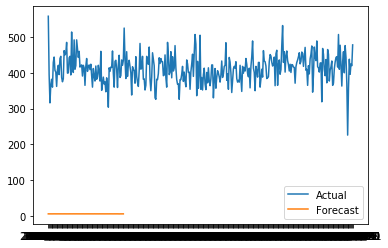

In [100]:
ax = plt.plot(v, label='Actual');
plt.plot(preds, label='Forecast');
plt.legend();


# Classification

In [101]:
c = pd.read_csv('Police_Department_Incidents_-_Previous_Year__2016_.csv')

In [102]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150500 entries, 0 to 150499
Data columns (total 13 columns):
IncidntNum    150500 non-null int64
Category      150500 non-null object
Descript      150500 non-null object
DayOfWeek     150500 non-null object
Date          150500 non-null object
Time          150500 non-null object
PdDistrict    150499 non-null object
Resolution    150500 non-null object
Address       150500 non-null object
X             150500 non-null float64
Y             150500 non-null float64
Location      150500 non-null object
PdId          150500 non-null int64
dtypes: float64(2), int64(2), object(9)
memory usage: 14.9+ MB


In [103]:
c['PdDistrict'] = c['PdDistrict'].ffill()

In [104]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150500 entries, 0 to 150499
Data columns (total 13 columns):
IncidntNum    150500 non-null int64
Category      150500 non-null object
Descript      150500 non-null object
DayOfWeek     150500 non-null object
Date          150500 non-null object
Time          150500 non-null object
PdDistrict    150500 non-null object
Resolution    150500 non-null object
Address       150500 non-null object
X             150500 non-null float64
Y             150500 non-null float64
Location      150500 non-null object
PdId          150500 non-null int64
dtypes: float64(2), int64(2), object(9)
memory usage: 14.9+ MB


Day, Time, Address    predict - category

In [105]:
cl = c[['DayOfWeek', 'Time', 'Address', 'Category']]

In [106]:
cl.head()

,DayOfWeek,Time,Address,Category
0,Friday,11:00,800 Block of BRYANT ST,WEAPON LAWS
1,Friday,11:00,800 Block of BRYANT ST,WEAPON LAWS
2,Monday,14:59,KEITH ST / SHAFTER AV,WARRANTS
3,Tuesday,23:50,JONES ST / OFARRELL ST,NON-CRIMINAL
4,Friday,00:30,16TH ST / MISSION ST,NON-CRIMINAL


In [107]:
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150500 entries, 0 to 150499
Data columns (total 4 columns):
DayOfWeek    150500 non-null object
Time         150500 non-null object
Address      150500 non-null object
Category     150500 non-null object
dtypes: object(4)
memory usage: 4.6+ MB


In [108]:
cl['DayOfWeek'] = le.fit_transform(cl['DayOfWeek'])
cl['Time'] = le.fit_transform(cl['Time'])
cl['Address'] = le.fit_transform(cl['Address'])
cl['Category'] = le.fit_transform(cl['Category'])

# cl['DayOfWeek'] = pd.factorize(cl['DayOfWeek'])[0]
# cl['Time'] = pd.factorize(cl['Time'])[0]
# cl['Address'] = pd.factorize(cl['Address'])[0]
# cl['Category'] = pd.factorize(cl['Category'])[0]

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [109]:
cl.head()

,DayOfWeek,Time,Address,Category
0,0,659,9419,38
1,0,659,9419,38
2,1,898,12995,37
3,5,1429,12884,20
4,0,29,3561,20


In [110]:
x = cl.drop('Category', axis = 1)
y = np.array(cl.Category).reshape(-1, 1)

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [112]:
ss = StandardScaler(with_mean = True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = 40)

In [113]:
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [114]:
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(class_weight='balanced', random_state=0, solver='saga', multi_class='ovr' )

In [115]:
logR.fit(x_train,y_train)
predictions = logR.predict(x_test)



/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [116]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.00      0.00      0.00      4176
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00      1718
           5       0.00      0.00      0.00       210
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00      1273
           8       0.00      0.00      0.00       140
           9       0.00      0.00      0.00        53
          10       0.00      0.05      0.00        21
          11       0.00      0.00      0.00        20
          12       0.00      0.00      0.00       188
          13       0.00      0.00      0.00       770
          14       0.00      0.33      0.00         9
          15       0.00      0.00      0.00        69
          16       0.00      0.00      0.00     12165
          17       0.00    

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
